In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import imageio
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output
import random

from bentley import BentleyBlizzardBlossoms

In [2]:
SIZE = 128
LATENT = 10
MODE = False

# Technically these are built-in, but they don't work with ONNX.js :(
# MODE switches between batched and single-instance, because ONNX.js isn't smart enough to detect shapes

class Flatten(torch.nn.Module):
    def forward(self, inp):
        return inp.view(1 if MODE else inp.shape[0], -1)

class Unflatten(torch.nn.Module):
    def __init__(self, *size):
        super().__init__()
        self.size = size

    def forward(self, inp):
        return inp.view(1 if MODE else inp.shape[0], *self.size)

class Frozone(torch.nn.Module):
    def __init__(self):
#         "Honey! Where's! my! super()! __init__()?!"
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=4),
            torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=4),
            Flatten(),
            torch.nn.Linear(in_features=SIZE*SIZE//16//16*6, out_features=50),
        )
        self.encode_mu = torch.nn.Linear(in_features=50, out_features=LATENT)
        self.encode_logvar = torch.nn.Linear(in_features=50, out_features=LATENT)
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=LATENT, out_features=50),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=50, out_features=50),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=50, out_features=SIZE*SIZE*4, bias=False),
            torch.nn.ReLU(),
            Unflatten(4, SIZE, SIZE),
            torch.nn.Conv2d(in_channels=4, out_channels=4, kernel_size=7, padding=3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3, padding=1)
        )
    
    def forward(self, x):
        y = self.encoder(x)
        mu = self.encode_mu(y)
        logvar = self.encode_logvar(y)
        
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + std * eps
        
        x_ = self.decoder(z)
#         mse_loss = ((x - x_) ** 2).sum() / (SIZE * SIZE)
        mse_loss = ((x - x_).abs()).sum() / (SIZE * SIZE)
        kld_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        
        return mse_loss, kld_loss

In [3]:
ds = BentleyBlizzardBlossoms('img', transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(999),
    transforms.Grayscale(),
    transforms.Resize([SIZE, SIZE]),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(180)
]))

In [4]:
dl = DataLoader(ds, batch_size=4, shuffle=True)
m = Frozone()
o = torch.optim.Adam(m.parameters(), lr=0.001)
losses = []

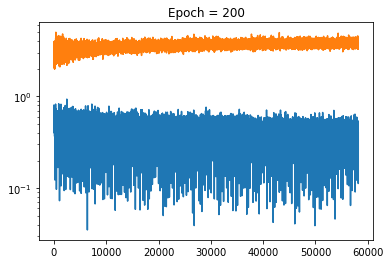

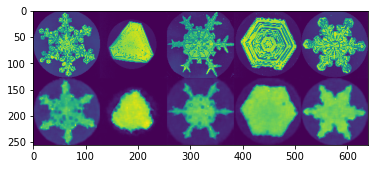

In [5]:
for epoch in range(201):
    if epoch % 5 == 0:
        torch.save(m.state_dict(), 'model3-epoch-%03d.pt' % epoch)
        with open('model.onnx', 'wb') as f:
            MODE = True
            torch.onnx.export(m.decoder, torch.randn(1, LATENT), f=f, opset_version=12)
            MODE = False
    for i, x in enumerate(dl):
        o.zero_grad()
        loss_mse, loss_kld = m(x['img'])
        loss = loss_mse + loss_kld / 1000
        loss.backward()
        losses.append([loss_mse.detach(), loss_kld.detach()])
        o.step()

        if i % 400 == 1:
            clear_output(wait=True)
            plt.plot(losses if len(losses) < 1000 else losses[1000:])
            plt.yscale('log')
            plt.title(f'Epoch = {epoch}')
            
            plt.figure()
            viz = []
            for _ in range(5):
                test_img = ds[random.randrange(len(ds))]['img']
                inp_img = test_img.squeeze(0)
                out_img = m.decoder(
                    m.encode_mu(m.encoder(test_img.unsqueeze(0)))
                ).detach().squeeze(0).squeeze(0)
                viz.append(torch.cat([inp_img, out_img], dim=0))
            plt.imshow(torch.cat(viz, dim=1))

            plt.show()